# Comparison to representational changes in experiments - Figure 4

Before you can run this notebook, make sure you run the following minimal set of experiments and anlaysis:
```
python lpl_main.py --dataset stl10 --no_biases --experiment_name bias_free_run --random_seed 1
```
Training this model as well as running this notebook requires a lot of GPU RAM. If you run out, you can try decreasing the batch size, but note that this may affect the results.

In [2]:
# Torch
import torch
import torch.nn as nn

# Lightning bolts
from pl_bolts.datamodules import CIFAR10DataModule, STL10DataModule, ImagenetDataModule
from pl_bolts.models.self_supervised.simclr import SimCLRTrainDataTransform, SimCLREvalDataTransform
from pl_bolts.transforms.dataset_normalizations import (
    cifar10_normalization,
    imagenet_normalization,
    stl10_normalization,
)
from pytorch_lightning import seed_everything
seed_everything(1)

# Numpy, scipy
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# System
import os
import tqdm

import project_path

from models.module import LPL

Global seed set to 1


In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

The path below specifies where the saved checkpoint model is located when the above command is run. If you change the experiment name or dataset, you will need to change the path below accordingly.

In [4]:
MODEL_DIR = os.path.expanduser("~/data/lpl/stl10/bias_free_run/lpl/checkpoints/")

file_names = os.listdir(MODEL_DIR)
file_names = [f for f in file_names if f.endswith(".ckpt")]
assert len(file_names) == 1, "More than one checkpoint found!"

MODEL_PATH = os.path.join(MODEL_DIR, file_names[0])

In [5]:
outputdir = os.path.expanduser("~/data/lpl/plots/fig_experimental_data")
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

## Image samples from STL-10

In [ ]:
# Reduce this to fit your GPU memory if necessary
batch_size = 128

In [ ]:
data_dir = os.path.expanduser("~/data/datasets/stl10")
h = 0  # image size

data_module = STL10DataModule(batch_size=batch_size, data_dir=data_dir)
normalization = stl10_normalization()
(c, h, w) = data_module.size()

data_module.train_transforms = SimCLRTrainDataTransform(h, normalize=normalization)
data_module.val_transforms = SimCLREvalDataTransform(h, normalize=normalization)
data_module.test_transforms = SimCLREvalDataTransform(h, normalize=normalization)
data_module.setup()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
def embedding_transform_random(batch):
    b, c, w, h = batch.shape
    out = torch.zeros_like(batch).repeat(1, 1, 13, 1)
    out[:, :, :w, :] = batch
    for i in range(b):
        out[i] = torch.roll(out[i], w*([0, 6, 12][torch.randint(3, (1, 1)).item()]), 1)
    return out

def embedding_transform_pos(batch, pos):
    b, c, w, h = batch.shape
    out = torch.zeros_like(batch).repeat(1, 1, 13, 1)
    out[:, :, :w, :] = batch
    out = torch.roll(out, w*pos, 2)
    return out

First, let's look at some sample images from the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


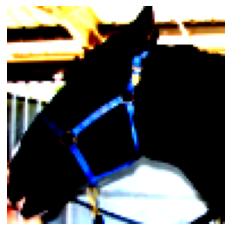

In [8]:
i = 0
for sample_batch in data_module.test_dataloader():
    if i == 2:
        plt.imshow(sample_batch[0][-1][6].permute(1,2,0))
        plt.axis('off')
        break
    i += 1

Now, let's place them on a large vertical canvas at different positions in order to simulate the experimental conditions. We define three positions on a 13x1 grid - the top, middle, and bottom.

In [9]:
transformed = embedding_transform_random(sample_batch[0][-1])
plt.imshow(transformed[4].permute(1,2,0))
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 95.5, 1247.5, -0.5)

In [10]:
transformed = embedding_transform_pos(sample_batch[0][-1], 0)
plt.imshow(transformed[3].permute(1,2,0))
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 95.5, 1247.5, -0.5)

## Helper functions for simulating swap experimental protocol

In [11]:
def return_transformed_and_embedded_image(x):
    P1 = x[:8]
    N1 = x[8:16]

    P2 = x[16:24]
    N2 = x[24:32]

    PC = x[32:40]
    NC = x[40:48]
    
    P1_swap = embedding_transform_pos(P1, 0).to('cuda')
    P1_center = embedding_transform_pos(P1, 6).to('cuda')
    P1_nonswap = embedding_transform_pos(P1, 12).to('cuda')
    N1_swap = embedding_transform_pos(N1, 0).to('cuda')
    N1_center = embedding_transform_pos(N1, 6).to('cuda')
    N1_nonswap = embedding_transform_pos(N1, 12).to('cuda')

    P2_swap = embedding_transform_pos(P2, 12).to('cuda')
    P2_center = embedding_transform_pos(P2, 6).to('cuda')
    P2_nonswap = embedding_transform_pos(P2, 0).to('cuda')
    N2_swap = embedding_transform_pos(N2, 12).to('cuda')
    N2_center = embedding_transform_pos(N2, 6).to('cuda')
    N2_nonswap = embedding_transform_pos(N2, 0).to('cuda')

    PC_top = embedding_transform_pos(PC, 0).to('cuda')
    PC_center = embedding_transform_pos(PC, 6).to('cuda')
    PC_bottom = embedding_transform_pos(PC, 12).to('cuda')
    NC_top = embedding_transform_pos(NC, 0).to('cuda')
    NC_center = embedding_transform_pos(NC, 6).to('cuda')
    NC_bottom = embedding_transform_pos(NC, 12).to('cuda')
    
    return P1_swap, P1_center, P1_nonswap, N1_swap, N1_center, N1_nonswap, P2_swap, P2_center, P2_nonswap, N2_swap, N2_center, N2_nonswap, PC_top, PC_center, PC_bottom, NC_top, NC_center, NC_bottom

In [12]:
def hebbian_loss(a, a_center=None, variance=None):
    if a_center is None:
        a_center = a.mean(dim=0).detach()
    if variance is None:
        variance = ((a - a_center) ** 2).sum(dim=0) / (a.shape[0] - 1)
    loss = -torch.log(variance + 1e-4).mean()
    return loss

def decorr_loss(a, a_center=None):
    if a_center is None:
        a_center = a.mean(dim=0)
    a_centered = a - a_center.detach()
    cov = torch.einsum('ij,ik->jk', a_centered, a_centered).fill_diagonal_(0) / (a.shape[0] - 1)
    loss = torch.sum(cov ** 2) / (cov.shape[0] ** 2 - cov.shape[0])
    return loss

def stack_spatial_features(a):
    b, c, w, h = a.shape
    a_stacked = a.view(b, c, -1).transpose(1, 2).reshape(-1, c)
    return a_stacked

def set_param_specific_optim_params(named_params, skip_list=None):
    if skip_list is None:
        skip_list = ['bias', 'bn', 'norm']
    params = []
    params_no_weight_decay = []

    for name, param in named_params:
        if not param.requires_grad:
            continue
        elif any(layer_name in name for layer_name in skip_list):
            params_no_weight_decay.append(param)
        else:
            params.append(param)
    return [{'params': params},
            {'params': params_no_weight_decay, 'weight_decay': 0.}]

In [13]:
decoding_pooler = nn.AdaptiveAvgPool2d((13, 1))

def get_conv_embedding(model, image, pool=True, readout_module=None, train_conv=False):
    _, fm, z_conv = model.network(image)
    
    z = fm[-1].detach()
    if pool:
        z = decoding_pooler(z)
    
    z = z.view(fm[-1].shape[0],-1)
    if readout_module is not None:
        assert pool, 'Must pool before readout'
        z = readout_module(z.detach())
    
    if train_conv:
        z_conv.append(z)
        return z_conv
    else:
        return [z]

In [14]:
def dicarlo_protocol(model, sample_batch, optimizers, readout, train_conv=False, num_epochs=400):

    delta_1 = torch.zeros(num_epochs, 3, 8, 512)
    delta_2 = torch.zeros(num_epochs, 3, 8, 512)
    delta_c = torch.zeros(num_epochs, 3, 8, 512)

    z_p = torch.zeros(num_epochs, 2, 8, 512)
    z_n = torch.zeros(num_epochs, 2, 8, 512)

    mse = nn.MSELoss()

    pull_losses = []
    push_losses = []
    decorr_losses = []

    for epoch in tqdm.trange(num_epochs):
        
        batch = sample_batch[0][-1]
        P1_swap, P1_center, P1_nonswap, N1_swap, N1_center, N1_nonswap, P2_swap, P2_center, P2_nonswap, N2_swap, N2_center, N2_nonswap, PC_top, PC_center, PC_bottom, NC_top, NC_center, NC_bottom = return_transformed_and_embedded_image(batch)

        zP1 = get_conv_embedding(model, P1_center, readout_module=readout, train_conv=train_conv)
        zN1 = get_conv_embedding(model, N1_center, readout_module=readout, train_conv=train_conv)
        zP2 = get_conv_embedding(model, P2_center, readout_module=readout, train_conv=train_conv)
        zN2 = get_conv_embedding(model, N2_center, readout_module=readout, train_conv=train_conv)

        zP1_nonswap = get_conv_embedding(model, P1_nonswap, readout_module=readout, train_conv=train_conv)
        zN1_nonswap = get_conv_embedding(model, N1_nonswap, readout_module=readout, train_conv=train_conv)
        zP2_nonswap = get_conv_embedding(model, P2_nonswap, readout_module=readout, train_conv=train_conv)
        zN2_nonswap = get_conv_embedding(model, N2_nonswap, readout_module=readout, train_conv=train_conv)

        zP1_swap = get_conv_embedding(model, P1_swap, readout_module=readout, train_conv=train_conv)
        zN1_swap = get_conv_embedding(model, N1_swap, readout_module=readout, train_conv=train_conv)
        zP2_swap = get_conv_embedding(model, P2_swap, readout_module=readout, train_conv=train_conv)
        zN2_swap = get_conv_embedding(model, N2_swap, readout_module=readout, train_conv=train_conv)

        yP1 = zP1[-1]
        yN1 = zN1[-1]
        yP2 = zP2[-1]
        yN2 = zN2[-1]

        yP1_nonswap = zP1_nonswap[-1]
        yN1_nonswap = zN1_nonswap[-1]
        yP2_nonswap = zP2_nonswap[-1]
        yN2_nonswap = zN2_nonswap[-1]

        yP1_swap = zP1_swap[-1]
        yN1_swap = zN1_swap[-1]
        yP2_swap = zP2_swap[-1]
        yN2_swap = zN2_swap[-1]

        yPC_top = get_conv_embedding(model, PC_top, readout_module=readout)[-1]
        yPC_center = get_conv_embedding(model, PC_center, readout_module=readout)[-1]
        yPC_bottom = get_conv_embedding(model, PC_bottom, readout_module=readout)[-1]
        yNC_top = get_conv_embedding(model, NC_top, readout_module=readout)[-1]
        yNC_center = get_conv_embedding(model, NC_center, readout_module=readout)[-1]
        yNC_bottom = get_conv_embedding(model, NC_bottom, readout_module=readout)[-1]

        delta_1[epoch, 0] = (yP1_nonswap - yN1_nonswap).clone().detach()
        delta_2[epoch, 0] = (yP2_nonswap - yN2_nonswap).clone().detach()
        delta_c[epoch, 0] = (yPC_top - yNC_top).clone().detach()

        delta_1[epoch, 1] = (yP1 - yN1).clone().detach()
        delta_2[epoch, 1] = (yP2 - yN2).clone().detach()
        delta_c[epoch, 1] = (yPC_center - yNC_center).clone().detach()

        delta_1[epoch, 2] = (yP1_swap - yN1_swap).clone().detach()
        delta_2[epoch, 2] = (yP2_swap - yN2_swap).clone().detach()
        delta_c[epoch, 2] = (yPC_bottom - yNC_bottom).clone().detach()

        z_p[epoch, 0] = yP1_swap.clone().detach()
        z_p[epoch, 1] = yP2_swap.clone().detach()
        z_n[epoch, 0] = yN1_swap.clone().detach()
        z_n[epoch, 1] = yN2_swap.clone().detach()

        pull_loss = torch.zeros(len(zP1))
        push_loss = torch.zeros_like(pull_loss)
        decorr_loss = torch.zeros_like(pull_loss)
        total_loss = 0.

        for i in range(len(zP1)):

            pull_loss[i] = (model.predictive_loss(zP1[i].detach(), zP1_nonswap[i]) + model.predictive_loss(zP1[i].detach(), zN1_swap[i]) + model.predictive_loss(zN1[i].detach(), zN1_nonswap[i]) + model.predictive_loss(zN1[i].detach(), zP1_swap[i]) + model.predictive_loss(zP2[i].detach(), zP2_nonswap[i]) + model.predictive_loss(zP2[i].detach(), zN2_swap[i]) + model.predictive_loss(zN2[i].detach(), zN2_nonswap[i]) + model.predictive_loss(zN2[i].detach(), zP2_swap[i]))/8

            zs_all = torch.cat([zP1[i], zN1[i], zP2[i], zN2[i], zP1_nonswap[i], zN1_nonswap[i], zP2_nonswap[i], zN2_nonswap[i], zP1_swap[i], zN1_swap[i], zP2_swap[i], zN2_swap[i]], dim=0).squeeze()
            push_loss[i] = model.push_loss_fn(zs_all)
            decorr_loss[i] = model.decorr_loss(zs_all)

            total_loss += model.hparams['pull_coeff'] * pull_loss[i] + \
                         model.hparams['push_coeff'] * push_loss[i] + \
                         model.hparams['decorr_coeff'] * decorr_loss[i]

        pull_losses.append(pull_loss[-1].clone().detach())
        push_losses.append(push_loss[-1].clone().detach())
        decorr_losses.append(decorr_loss[-1].clone().detach())

        for optimizer in optimizers:
            optimizer.zero_grad()
        total_loss.backward()
        for optimizer in optimizers:
            optimizer.step()

    delta_1[:, :, idxs1] = -delta_1[:, :, idxs1]
    delta_2[:, :, idxs2] = -delta_2[:, :, idxs2]
    delta_c[:, :, idxsC] = -delta_c[:, :, idxsC]

    temp = z_p.clone()
    z_p[:, 0, idxs1] = z_n[:, 0, idxs1]
    z_p[:, 1, idxs2] = z_n[:, 1, idxs2]
    z_n[:, 0, idxs1] = temp[:, 0, idxs1]
    z_n[:, 1, idxs2] = temp[:, 1, idxs2]
    
    return delta_1, delta_2, delta_c, z_p, z_n, pull_losses, push_losses, decorr_losses

### Monkey IT recordings (experimental data)
Extracted manually from *Li, N., & DiCarlo, J. J. (2008). Unsupervised natural experience rapidly alters invariant object representation in visual cortex. science, 321(5895), 1502-1507.*

These will be used later to generate the final plots.

In [15]:
exposures = torch.tensor([0, 100, 200, 300, 400])

y_swap = torch.tensor([10.78, 8.85, 8.36, 6.33, 6.11])
y_swap_bottom = torch.tensor([5.91, 5.04, 4.76, 3.44, 3.24])
y_swap_top= torch.tensor([14.99, 12.54, 12, 9.15, 8.82])
y_swap_err = (y_swap_top -  y_swap_bottom)/2

y_nonswap = torch.tensor([9.26, 8.29, 8.52, 9.08, 8.41])
y_nonswap_bottom = torch.tensor([5.58, 5.25, 4.87, 5.55, 5.26])
y_nonswap_top = torch.tensor([12.94, 11.27, 12.13, 12.6, 11.42])
y_nonswap_err = (y_nonswap_top -  y_nonswap_bottom)/2

y_control = torch.tensor([4.15, 4.94, 3, 4.21, 3.76])
y_control_bottom = torch.tensor([1.71, 3.32, 1.44, 2.4, 1.23])
y_control_top = torch.tensor([6.49, 6.61, 4.48, 6.08, 6.24])
y_control_err = (y_control_top -  y_control_bottom)/2

In [16]:
exposures = torch.tensor([0, 100, 200, 300, 400])

P = torch.tensor([12.59, 11.81, 11.64, 10.89, 10.48])/10
P_bottom = torch.tensor([11.84, 10.96, 10.51, 10.08, 9.63])/10
P_top= torch.tensor([13.42, 12.61, 12.74, 11.71, 11.28])/10
P_err = (P_top -  P_bottom)/2

N = torch.tensor([6.28, 6.73, 7.04, 7.28, 7.32])/10
N_bottom = torch.tensor([5.56, 5.89, 6.26, 6.50, 6.54])/10
N_top= torch.tensor([6.93, 7.56, 7.85, 8.12, 8.09])/10
N_err = (N_top -  N_bottom)/2

mean_response = (P.mean() + N.mean())/2

## Functions for generating final plots

In [17]:
def generate_delta_panels(delta_1, delta_2, delta_c, figname, ymin, ymax):
    fig = plt.figure(figsize=(4.8, 3), dpi=200)
    grid = GridSpec(2, 3, figure=fig)

    ax = fig.add_subplot(grid[0])
    x, y, yerr = return_plot_quantities(torch.cat((delta_1[:, 2], delta_2[:, 2]), dim=1))
    ax.plot(x, y, color='#BB5566')
    ax.hlines(y[0], x[0], x[-1], linestyle='--', color='k')
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2, color='#BB5566')
    ax.set_title('Swap position', fontsize=8)
    ax.set_ylabel('Object selectivity\n' + r'$\Delta(P-N)$ (au)', fontsize=8)
    ax.set_ylim(ymin, ymax)
    ax.tick_params(axis = 'both', which = 'major', labelsize=8)
    np.savetxt(os.path.join(outputdir, 'delta_swap_model.csv'), np.vstack((x, y, yerr)).T, delimiter=',', header='exposures, delta, delta_err')

    ax = fig.add_subplot(grid[1])
    x, y, yerr = return_plot_quantities(torch.cat((delta_1[:, 0], delta_2[:, 0]), dim=1))
    ax.plot(x, y, color='k')
    ax.hlines(y[0], x[0], x[-1], linestyle='--', color='k')
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2, color='k')
    ax.set_title('Non-swap position', fontsize=8)
    ax.set_ylim(ymin, ymax)
    ax.tick_params(axis = 'both', which = 'major', labelsize=8)
    np.savetxt(os.path.join(outputdir, 'delta_nonswap_model.csv'), np.vstack((x, y, yerr)).T, delimiter=',', header='exposures, delta, delta_err')

    ax = fig.add_subplot(grid[2])
    x, y, yerr = return_plot_quantities(torch.cat((delta_c[:, 0], delta_c[:, 1], delta_c[:, 2]), dim=1))
    ax.plot(x, y, color='k')
    ax.hlines(y[0], x[0], x[-1], linestyle='--', color='k')
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2, color='k')
    ax.set_title('Swap position', fontsize=8)
    ax.set_ylim(ymin, ymax)
    ax.tick_params(axis = 'both', which = 'major', labelsize=8)
    np.savetxt(os.path.join(outputdir, 'delta_control_model.csv'), np.vstack((x, y, yerr)).T, delimiter=',', header='exposures, delta, delta_err')

    ax = fig.add_subplot(grid[3])
    ax.errorbar(exposures, y_swap, yerr = y_swap_err, marker='.', color='#BB5566')
    ax.hlines(y_swap[0], exposures[0], exposures[-1], linestyle='--', color='k')
    ax.set_ylabel('Object selectivity\n' + r'$\Delta(P-N)$ (spikes/s)', fontsize=8)
    ax.set_xlabel('Swap exposures', fontsize=8)
    ax.set_ylim(0, 15)
    ax.tick_params(axis = 'both', which = 'major', labelsize=8)

    ax = fig.add_subplot(grid[4])
    ax.errorbar(exposures, y_nonswap, yerr = y_nonswap_err, marker='.', color='k')
    ax.hlines(y_nonswap[0], exposures[0], exposures[-1], linestyle='--', color='k')
    ax.set_xlabel('Swap exposures', fontsize=8)
    ax.set_ylim(0, 15)
    ax.tick_params(axis = 'both', which = 'major', labelsize=8)

    ax = fig.add_subplot(grid[5])
    ax.errorbar(exposures, y_control, yerr = y_control_err, marker='.', color='k')
    ax.hlines(y_control[0], exposures[0], exposures[-1], linestyle='--', color='k')
    ax.set_xlabel('Swap exposures', fontsize=8)
    ax.set_ylim(0, 8)
    ax.tick_params(axis = 'both', which = 'major', labelsize=8)

    sns.despine()
    plt.savefig(os.path.join(outputdir, figname), bbox_inches='tight', backend='pgf')
    plt.show()

In [18]:
def generate_response_panels(z_p, z_n, figname):
    fig = plt.figure(figsize=(1.8, 3), dpi=300)
    grid = GridSpec(2, 1, figure=fig)

    x = list(range(len(z_p)))
    ax = fig.add_subplot(grid[0])
    ax.plot(x, z_p[:,1].view(z_p.shape[0], -1).mean(-1).detach(), label='P', color='#BB5566')
    ax.plot(x, z_n[:,1].view(z_p.shape[0], -1).mean(-1).detach(), label='N', color='#004488')
    ax.hlines(0.5*(z_p[0,1].mean() + z_n[0,1].mean()), x[0], x[-1], linestyle='--', color='k')
    num_samples = np.sqrt(z_p.shape[-1])
    ax.fill_between(x, z_p[:,1].view(z_p.shape[0], -1).mean(-1).detach() - z_p[:,1].view(z_p.shape[0], -1).std(-1).detach()/num_samples, z_p[:,1].view(z_p.shape[0], -1).mean(-1).detach() + z_p[:,1].view(z_p.shape[0], -1).std(-1).detach()/num_samples, alpha=0.2, color='#BB5566')
    ax.fill_between(x, z_n[:,1].view(z_p.shape[0], -1).mean(-1).detach() - z_n[:,1].view(z_p.shape[0], -1).std(-1).detach()/num_samples, z_n[:,1].view(z_p.shape[0], -1).mean(-1).detach() + z_n[:,1].view(z_p.shape[0], -1).std(-1).detach()/num_samples, alpha=0.2, color='#004488')
    # plt.legend()
    # plt.ylabel('Object sensitivity')
    ax.set_title(' ', fontsize=8)
    ax.tick_params(axis = 'both', which = 'major', labelsize=8)
    np.savetxt(os.path.join(outputdir, 'z_p_model.csv'), z_p[:,1].view(z_p.shape[0], -1).mean(-1).detach().numpy(), delimiter=',', header='P')
    np.savetxt(os.path.join(outputdir, 'z_n_model.csv'), z_n[:,1].view(z_p.shape[0], -1).mean(-1).detach().numpy(), delimiter=',', header='N')

    ax = fig.add_subplot(grid[1])
    ax.errorbar(exposures, P, yerr = P_err, marker='.', color='#BB5566')
    ax.errorbar(exposures, N, yerr = N_err, marker='.', color='#004488')
    ax.hlines(mean_response, exposures[0], exposures[-1], linestyle='--', color='k')
    ax.set_ylim(0.5, 1.5)
    # plt.legend()
    ax.set_xlabel('Swap exposures', fontsize=8)
    ax.tick_params(axis = 'both', which = 'major', labelsize=8)
    # plt.ylabel('Object sensitivity')

    sns.despine()
    plt.savefig(os.path.join(outputdir, figname), bbox_inches='tight', backend='pgf')
    plt.show()

In [19]:
def return_plot_quantities(delta):
    x = list(range(len(delta)))
    y = delta.detach().view(delta.shape[0], -1).mean(-1)
    yerr = delta.detach().view(delta.shape[0], -1).std(-1)/np.sqrt(delta.shape[-1]*delta.shape[-2])
    return x, y, yerr

In [20]:
plt.rcParams['figure.constrained_layout.use'] = True

## Fine-tuning a new dense layer

We need to train a new dense layer on top of the frozen encoder to learn positional invariance with respect to the different positions on the canvas. We'll use the same loss function as for initial self-supervised training with the same hyperparameters.

The following code trains a dense layer for 10 epochs and saves the weights to a new checkpoint file the first time you run it.

In [ ]:
path = MODEL_PATH

model = LPL.load_from_checkpoint(path, strict=False).to('cuda')

load_readout = True
readout_file = 'readout_stl.pt'
num_epochs = 10


if load_readout and os.path.exists(readout_file):
    readout = torch.load(readout_file)
else:
    readout = nn.Linear(13*model.z_dim, model.z_dim).to('cuda')
    parameters = set_param_specific_optim_params(readout.named_parameters())
    optimizer = torch.optim.Adam(parameters, lr=model.hparams['learning_rate'], weight_decay=model.hparams['weight_decay'])

    for epoch in range(num_epochs):
        for train_batch in tqdm.tqdm(data_module.train_dataloader()):
            x1 = embedding_transform_random(train_batch[0][0].to('cuda'))
            x2 = embedding_transform_random(train_batch[0][1].to('cuda'))

            z1 = get_conv_embedding(model, x1, readout_module=readout)[-1]
            z2 = get_conv_embedding(model, x2, readout_module=readout)[-1]

            zs_all = torch.cat([z1, z2], dim=0).squeeze()

            loss = model.hparams['pull_coeff']*model.predictive_loss(z1, z2) + model.hparams['push_coeff']*model.push_loss_fn(zs_all) + model.hparams['decorr_coeff']*model.decorr_loss(zs_all)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(readout, readout_file)

Let's select one mini-batch of images from the validation set and plot the activations of the new dense layer for each position on the canvas. This mini-batch will also be used as the set of images for simulating the swap experiment. From the mini-batch, we select three sets of 16 images (or 8 pairs) each - one set for swapping at the top, one for swapping at the bottom, and one set of non-swapped control images. The number of images is chosen according to the what was used in the original experiment.

Since we will be using a very small set of images, the following results can vary depending on the specific set of images selected and may not be exactly the same as the results we have reported in the paper. However, the overall trends should remain the same. If you like, you can change the `batch_number_to_select` variable below to select a different set of images.

In [22]:
batch_number_to_select = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


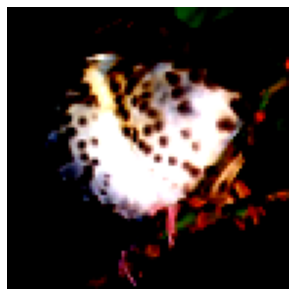

In [23]:
i = 0
data_module.batch_size = 192
for sample_batch in data_module.test_dataloader():
    if i == batch_number_to_select:
        plt.imshow(sample_batch[0][-1][6].permute(1,2,0))
        plt.axis('off')
        break
    i += 1

In [24]:
representations = []
representations_pos_1 = get_conv_embedding(model, embedding_transform_pos(sample_batch[0][-1][:48], 0).to('cuda').detach(), readout_module=readout)[-1]
representations_pos_c = get_conv_embedding(model, embedding_transform_pos(sample_batch[0][-1][:48], 6).to('cuda').detach(), readout_module=readout)[-1]
representations_pos_2 = get_conv_embedding(model, embedding_transform_pos(sample_batch[0][-1][:48], 12).to('cuda').detach(), readout_module=readout)[-1]

representations = torch.stack([representations_pos_1, representations_pos_c, representations_pos_2]).cpu()

Let's plot the representations of the images in different positions on the canvas, normalized by the activations corresponding to the middle position. This is the same normalization used in the original experiment, and should demonstrate that the representations are position-invariant. Some minor differences are expected due to the small mini-batch size.

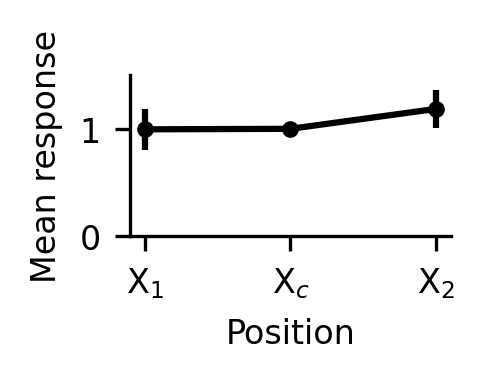

In [25]:
plt.figure(figsize=(1.5,1), dpi=300)

flattened_representations = representations.view(3, -1)
flattened_representations = flattened_representations[:, torch.abs(flattened_representations[1])>0.0001]
normalized_representations = flattened_representations/flattened_representations[1]
y = normalized_representations.detach().mean(dim=-1).cpu()
yerr = normalized_representations.detach().std(dim=-1).cpu()/np.sqrt(normalized_representations.shape[-1])
plt.errorbar([0,1,2], y, yerr, marker='o', markersize=3, color='k')

plt.xlabel('Position', fontsize=8)
plt.ylabel('Mean response', fontsize=8)
plt.ylim(0., 1.5)

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.set_xticks([0,1,2])
ax.set_xticklabels([r'$\mathrm{X}_1$',r'$\mathrm{X}_c$',r'$\mathrm{X}_2$'])
sns.despine()

plt.savefig(os.path.join(outputdir, 'position_invariance.pdf'), bbox_inches='tight', backend='pgf')

In [26]:
representations.shape

torch.Size([3, 48, 512])

In [27]:
idxs1 = representations[1, :8] < representations[1, 8:16]

idxs2 = representations[1, 16:24] < representations[1, 24:32]

idxsC = representations[1, 32:40] < representations[1, 40:48]

In [28]:
idxs1.shape

torch.Size([8, 512])

In [29]:
representations.shape

torch.Size([3, 48, 512])

## Swap experimental protocol

Now to simulate the experiment with the set of images we just selected.

In [ ]:
learning_rate_conv = 1e-7
learning_rate_dense = 2e-2
weight_decay = 1.5e-6
train_conv = True
recover_optimizer_context = True

model = LPL.load_from_checkpoint(path, strict=False).to('cuda')

readout = torch.load('readout_stl.pt')
parameters = set_param_specific_optim_params(readout.named_parameters())
optimizers = [torch.optim.SGD(parameters, lr=learning_rate_dense, weight_decay=weight_decay)]

if train_conv:
    conv_parameters = set_param_specific_optim_params(model.named_parameters())
    checkpoint = torch.load(path)
    conv_optimizer = torch.optim.Adam(conv_parameters, weight_decay=weight_decay)
    if recover_optimizer_context:
        conv_optimizer.load_state_dict(checkpoint['optimizer_states'][0])
    for param_group in conv_optimizer.param_groups:
        param_group['lr'] = learning_rate_conv
    optimizers.append(conv_optimizer)

delta_1, delta_2, delta_c, z_p, z_n, pull_losses, push_losses, decorr_losses = dicarlo_protocol(model, sample_batch, optimizers, readout, train_conv=train_conv)

First, let's plot the loss curves during training with the experimental swap protocol.

/tmp/ipykernel_2877329/3858531748.py:15: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


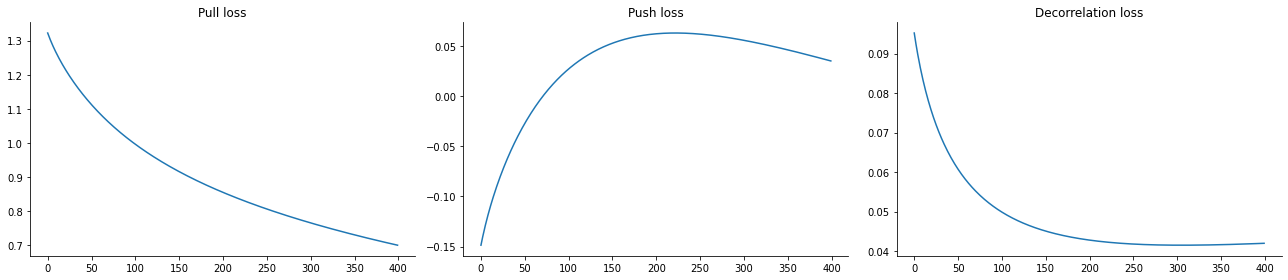

In [ ]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(pull_losses)
plt.title('Pull loss')

plt.subplot(1, 3, 2)
plt.plot(push_losses)
plt.title('Push loss')

plt.subplot(1, 3, 3)
plt.plot(decorr_losses)
plt.title('Decorrelation loss')

plt.tight_layout()

sns.despine()

And now the final plot of the results

torch.Size([400, 16, 512])
torch.Size([400, 16, 512])
torch.Size([400, 24, 512])


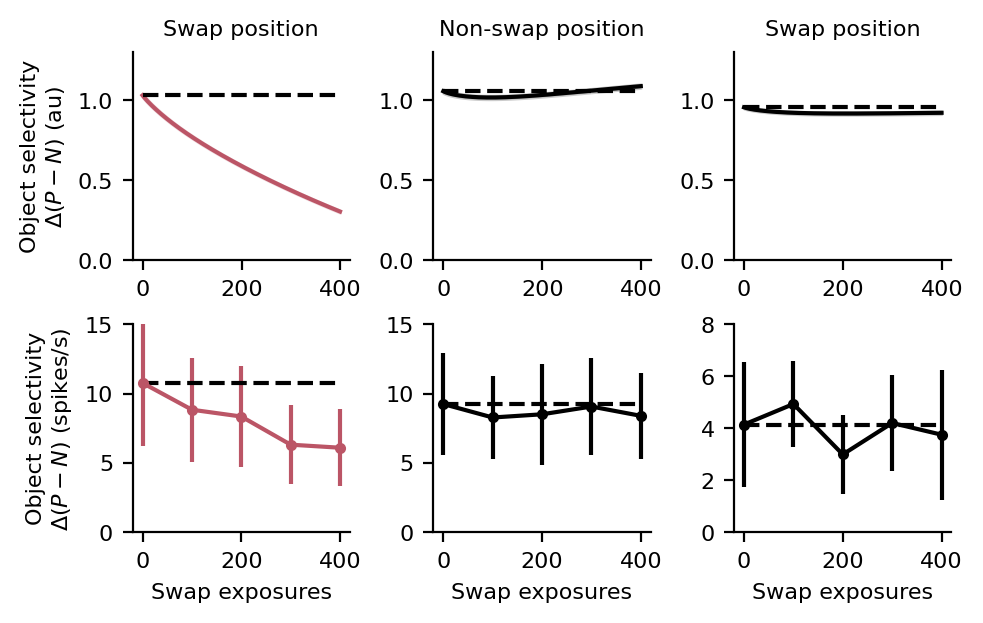

In [ ]:
generate_delta_panels(delta_1, delta_2, delta_c, 'stl_delta.pdf', 0.0, 1.3)

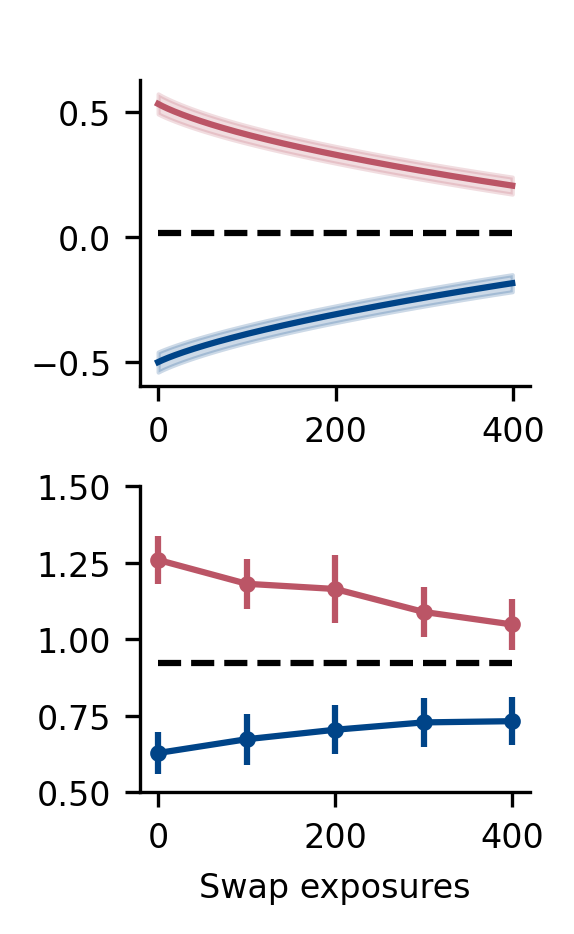

In [ ]:
generate_response_panels(z_p, z_n, 'stl_response_changes.pdf')